## Import libraries

In [1]:
import os
import glob
import pickle
from pathlib import Path, PureWindowsPath

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 

## Config

In [2]:
class cfg:

    THIS_NOTEBOOK_ID: "FR_t01e01nb04v1"

    #=================================================
    ROOT_TRAINING_RSLTS = os.path.join('..', '..', '..',
                                       "results",
                                       "exp_track",
                                      )

## Utility functions

### flatten_dict()

In [3]:
def flatten_dict(d, parent_key='', sep='_'):
    """
    Description
    -----------
        Recursive, inspect inner dict and extract values

    Return: 
    ------
        flat_dictionary: It can be use as one row of a dataframe.
    """
    
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k

        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))

    return dict(items)

### perf_last_epoch_metric_distr_info()

In [19]:
def perf_last_epoch_metric_distr_info(d_meta, 
                                      arch_name_wild_card="resnet", 
                                      pipe_names=['pipe001']): 
    
    """
    Description:
    -----------
        Selecting and extracting performances on test for each fold, and then calculating
            distribution information "'mean', 'std', 'min', '25%', '50%', '75%', 'max'" 
            
    Parameters:
    -----------
        arch_name_wild_card: to select the architecture of interest
        pipe_names: list of preprocessing image pipeline id of interest

    Return: 
        d_m: dataframe organize to show for each training track id, the test performances across folds.

    """
    
    c1 = d_meta['architecture__arch_ID'].str.lower().str.contains(arch_name_wild_card)
    c2 = d_meta['prepro_pipe__pipe_name'].isin(pipe_names)
    
    d = d_meta[c1&c2].reset_index(drop=True)
    d
    
    
    #==========================================
    # Extracting performances, fold, leakage or not leakage
    track_slct_info = []
    for r, data in d.iterrows():
    
        #- - - - - - - - - - - - - - - - - 
        # Extracting information related to performance per epoch during training process. 
        fpath = data['path_perf_dct']
        with open(fpath, 'rb') as f:
            perf_dct = pickle.load(f)
            """
            perf_dct keys: 
                ['prcsn_trn', 'f1score_trn', 'rec_trn', 'ba_trn', 'acc_trn', 'loss_trn', 
                 'prcsn_tst', 'f1score_tst', 'rec_tst', 'ba_tst', 'acc_tst', 'loss_tst', 
                 'lr', 'track_train_id', 'fold_id', 'arch_id']
    
            """
            
        
    
        #- - - - - - - - - - - - - - - - - 
        track_slct_info.append([
            data['track_train_id'], 
            data['architecture__arch_ID'],
            data['fold_id'], 
            data['path_perf_dct'], 
            data['prepro_pipe__pipe_name'],
            data['split_strategy__shuffle_instances'], #True:leakage, False: 'no_leakage'
            data["training_step__epochs"],
            perf_dct['acc_tst'][-1], # last epoch performance
            perf_dct['ba_tst'][-1], # last epoch performance
            perf_dct['f1score_tst'][-1], # last epoch performance
            perf_dct['prcsn_tst'][-1], # last epoch performance
            perf_dct['rec_tst'][-1], # last epoch performance
        ])
    
        #_____________________________________
        # break
    #_________________________________________
    
    
    #===========================================================
    # Extracting test performance of last epoch of each fold. 
    cols = ['track_train_id', 'arch_name', 'fold_id', 'path_perf_dct', 'prepro_pipe__pipe_name', 
            'leakage', 'training_step__epochs', 'acc_tst', 'ba_tst', 'f1score_tst', 'prcsn_tst', 'rec_tst']
    d_m = pd.DataFrame(track_slct_info, columns=cols)
    d_m
    
    #===========================================================
    # Extracting summary (across fold) for same Track_ID
    metrics_dist_info = []
    for gr, data in d_m.groupby(['track_train_id', 'prepro_pipe__pipe_name', 'arch_name', 'leakage', 'training_step__epochs']): 
        #___________________________________________________
        # Calculating test metrics performance distribution info (last training epoch)
        cols = ['acc_tst', 'ba_tst', 'f1score_tst', 'prcsn_tst', 'rec_tst']
        d = data[cols].describe().T.reset_index().rename(columns={'index':'metrics'})
        
        #___________________________________________________
        # Adding meta info
        d[['track_train_id', 'pre_pipe_id', 'arch_name', 'leakage', 'n_epochs']] = gr
        
        #___________________________________________________
        # Reorganization of table
        cols = ['track_train_id', 'pre_pipe_id', 'arch_name', 'leakage', 'n_epochs', 
                'metrics', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max',]
        d = d[cols]
        d = d.rename(columns={'count':'fold_cnt'})
        
        #___________________________________________________
        # Store
        metrics_dist_info.append(d)
    
        #___________________________________________________
        # break
    #_______________________________________________________
    d_m = pd.concat(metrics_dist_info,  ignore_index=True)
    d_m = d_m.sort_values(by=["leakage", "track_train_id", 'pre_pipe_id', 'arch_name'], ignore_index=True)

    return d_m

## Extract performance during training epochs

In [5]:
#=====================================================================
# READ DATA
ROOT_DATA = cfg.ROOT_TRAINING_RSLTS

model_epo_perf = glob.glob(os.path.join(ROOT_DATA, '*', 'perform_acrss_epo', "*", "performance_across_Epochs.pkl"))
model_epo_perf

#=====================================================================
# LOOP across each perforamnce directory
perf_meta = []
for p in model_epo_perf: 

    #_____________
    # Read file
    with open(p, 'rb') as f:
        perf_dct = pickle.load(f)

    #_____________
    # Extract keys
    trnTrackID = perf_dct['track_train_id']
    foldID = perf_dct['fold_id'] # nomenclature: f"seed{random_state in Kfold fun}_fold(n of data splits)
    archID = perf_dct['arch_id']

    perf_meta.append([trnTrackID, 
                      foldID, 
                      archID, 
                      p, 
                     ])

    #_________________________________________________
    # break
#=====================================================================
# Create metadatabase for perforamnces during training epochs during training.
cols = ['track_train_id', 'fold_id', 'arch_id', 'path_perf_dct']
d_prf_meta = pd.DataFrame(perf_meta, columns=cols)
d_prf_meta.head()

,track_train_id,fold_id,arch_id,path_perf_dct
0,TrainTrack_001,seed0_fold0,vanilla2DCNN_v1,../../../results/exp_track/TrainTrack_001/perf...
1,TrainTrack_002,seed0_fold0,vanilla2DCNN_v1,../../../results/exp_track/TrainTrack_002/perf...
2,TrainTrack_003,seed0_fold0,RESNET_v1,../../../results/exp_track/TrainTrack_003/perf...
3,TrainTrack_003,seed0_fold1,RESNET_v1,../../../results/exp_track/TrainTrack_003/perf...
4,TrainTrack_003,seed0_fold2,RESNET_v1,../../../results/exp_track/TrainTrack_003/perf...


In [6]:
pickle_fpath = d_prf_meta["path_perf_dct"][0]
with open(pickle_fpath, 'rb') as f:
    perf_dct = pickle.load(f)

perf_dct.keys()

dict_keys(['prcsn_trn', 'f1score_trn', 'rec_trn', 'ba_trn', 'acc_trn', 'loss_trn', 'prcsn_tst', 'f1score_tst', 'rec_tst', 'ba_tst', 'acc_tst', 'loss_tst', 'lr', 'track_train_id', 'fold_id', 'arch_id'])

**performance_across_Epochs.pkl:**
- For each epoch it calculates and stores performance metrics for training and test sets

## Extract Params for the whole ML pipeline

In [7]:
ROOT_DATA = cfg.ROOT_TRAINING_RSLTS

ml_pipe_params_paths = glob.glob(os.path.join(ROOT_DATA, '*', 'ML_pipe_params', "ML_pipe_all_params_*.pkl"))
ml_pipe_params_paths

#=========================================================================
# LOOP across each perforamnce directory
ml_parms_meta = []
for p in ml_pipe_params_paths:

    #________________________
    # Read file 
    with open(p, 'rb') as f:
        ml_pipe_parms_dct = pickle.load(f)
    #________________________
    # Flat dictionary
    flat_dct = flatten_dict(ml_pipe_parms_dct, parent_key='', sep='__')

    
    #________________________
    # Store
    ml_parms_meta.append(flat_dct)

    #________________________
    # break
#----------------------------
# if a dictionary key is missing in some Training Track IDs, due to diff architecture, training, etc
#  -- it needs to be added with Nan values. <<--- Pending
d_ml_pipe_params = pd.DataFrame(ml_parms_meta)
d_ml_pipe_params.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   prepro_pipe__pipe_name                8 non-null      object 
 1   prepro_pipe__source_code              8 non-null      object 
 2   architecture__arch_ID                 8 non-null      object 
 3   architecture__params__in_channels     2 non-null      float64
 4   architecture__params__num_classes     8 non-null      int64  
 5   architecture__source_code             8 non-null      object 
 6   split_strategy__cv                    8 non-null      object 
 7   split_strategy__n_split               8 non-null      int64  
 8   split_strategy__cls_col               8 non-null      object 
 9   split_strategy__inst_n_order_col      8 non-null      object 
 10  split_strategy__shuffle_instances     8 non-null      bool   
 11  split_strategy__seed   

## Extract prediction (y_pred per instance) of final training epoch

In [8]:
split_rslts = "test_result.csv" # last training epoch of that training track

ROOT_DATA = cfg.ROOT_TRAINING_RSLTS

ypred_rslts_paths = glob.glob(os.path.join(ROOT_DATA, "*", "predictions", "*", split_rslts,))
ypred_rslts_paths

['../../../results/exp_track/TrainTrack_001/predictions/seed0_fold0/test_result.csv',
 '../../../results/exp_track/TrainTrack_002/predictions/seed0_fold0/test_result.csv',
 '../../../results/exp_track/TrainTrack_003/predictions/seed0_fold0/test_result.csv',
 '../../../results/exp_track/TrainTrack_003/predictions/seed0_fold1/test_result.csv',
 '../../../results/exp_track/TrainTrack_003/predictions/seed0_fold2/test_result.csv',
 '../../../results/exp_track/TrainTrack_003/predictions/seed0_fold3/test_result.csv',
 '../../../results/exp_track/TrainTrack_003/predictions/seed0_fold4/test_result.csv',
 '../../../results/exp_track/TrainTrack_004/predictions/seed0_fold0/test_result.csv',
 '../../../results/exp_track/TrainTrack_004/predictions/seed0_fold1/test_result.csv',
 '../../../results/exp_track/TrainTrack_004/predictions/seed0_fold2/test_result.csv',
 '../../../results/exp_track/TrainTrack_004/predictions/seed0_fold3/test_result.csv',
 '../../../results/exp_track/TrainTrack_004/prediction

In [9]:
tst_rslts = pd.read_csv(ypred_rslts_paths[0])
tst_rslts["y_true"].value_counts()

y_true
2    113
0     84
1     24
Name: count, dtype: int64

In [10]:
tst_rslts["y_true"].shape

(221,)

In [11]:
class_counts = tst_rslts["y_true"].value_counts(normalize=True)  # gives class proportions
class_counts

y_true
2    0.511312
0    0.380090
1    0.108597
Name: proportion, dtype: float64

In [12]:
class_counts = tst_rslts["y_true"].value_counts(normalize=True)  # gives class proportions
expected_random_accuracy = (class_counts ** 2).sum()
expected_random_accuracy

0.4177023402469236

## TRACK META - GLobal

**This DataFrame will contain all information related to:**
- Complete DL Pipelines
- path to pickle file that contains the metric performance calculated during training epochs

In [13]:
d_meta = d_prf_meta.merge(d_ml_pipe_params,
                          how="left",
                          left_on="track_train_id",
                          right_on="training_step__TrackID")
d_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   track_train_id                        32 non-null     object 
 1   fold_id                               32 non-null     object 
 2   arch_id                               32 non-null     object 
 3   path_perf_dct                         32 non-null     object 
 4   prepro_pipe__pipe_name                32 non-null     object 
 5   prepro_pipe__source_code              32 non-null     object 
 6   architecture__arch_ID                 32 non-null     object 
 7   architecture__params__in_channels     2 non-null      float64
 8   architecture__params__num_classes     32 non-null     int64  
 9   architecture__source_code             32 non-null     object 
 10  split_strategy__cv                    32 non-null     object 
 11  split_strategy__n_spl

## VIZ Performances comparison

In [14]:
metric = 'acc_tst'
#==================================
metric_perf = []
for r, data in d_meta.iterrows():
    
    #---------------------------------------
    # Load performance during training epochs.
    performance_during_training_path = Path(PureWindowsPath(data["path_perf_dct"]))
    with open(performance_during_training_path, 'rb') as f:
        perf_dct = pickle.load(f)
        """
        Keys: 
            ['prcsn_trn', 'f1score_trn', 'rec_trn', 'ba_trn', 'acc_trn', 'loss_trn', 
             'prcsn_tst', 'f1score_tst', 'rec_tst', 'ba_tst', 'acc_tst', 'loss_tst', 
             'lr', 'track_train_id', 'fold_id', 'arch_id']

        """

    #---------------------------------------
    # Extracting metric performance selected during training epochs. 
    metric_perf.append((data["track_train_id"], 
                        perf_dct[metric],
                        data["split_strategy__shuffle_instances"]
                       ),
                       )

    #________________________________________________
    # break
#---------------------------------------------------
cols = ["track_train_id", "metric_vals", "leak"]
d_metric_perf = pd.DataFrame(metric_perf, columns=cols)
d_metric_perf

,track_train_id,metric_vals,leak
0,TrainTrack_001,"[0.7149321266968326, 0.9140271493212669, 0.977...",True
1,TrainTrack_002,"[0.3891402714932127, 0.5520361990950227, 0.493...",False
2,TrainTrack_003,"[0.4117647058823529, 0.3393665158371041, 0.434...",True
3,TrainTrack_003,"[0.4474885844748858, 0.4337899543378995, 0.383...",True
4,TrainTrack_003,"[0.3744292237442922, 0.410958904109589, 0.4292...",True
5,TrainTrack_003,"[0.4063926940639269, 0.4155251141552511, 0.465...",True
6,TrainTrack_003,"[0.4429223744292237, 0.3972602739726027, 0.420...",True
7,TrainTrack_004,"[0.3438914027149321, 0.45701357466063347, 0.30...",False
8,TrainTrack_004,"[0.3150684931506849, 0.3789954337899543, 0.287...",False
9,TrainTrack_004,"[0.3470319634703196, 0.4246575342465753, 0.479...",False


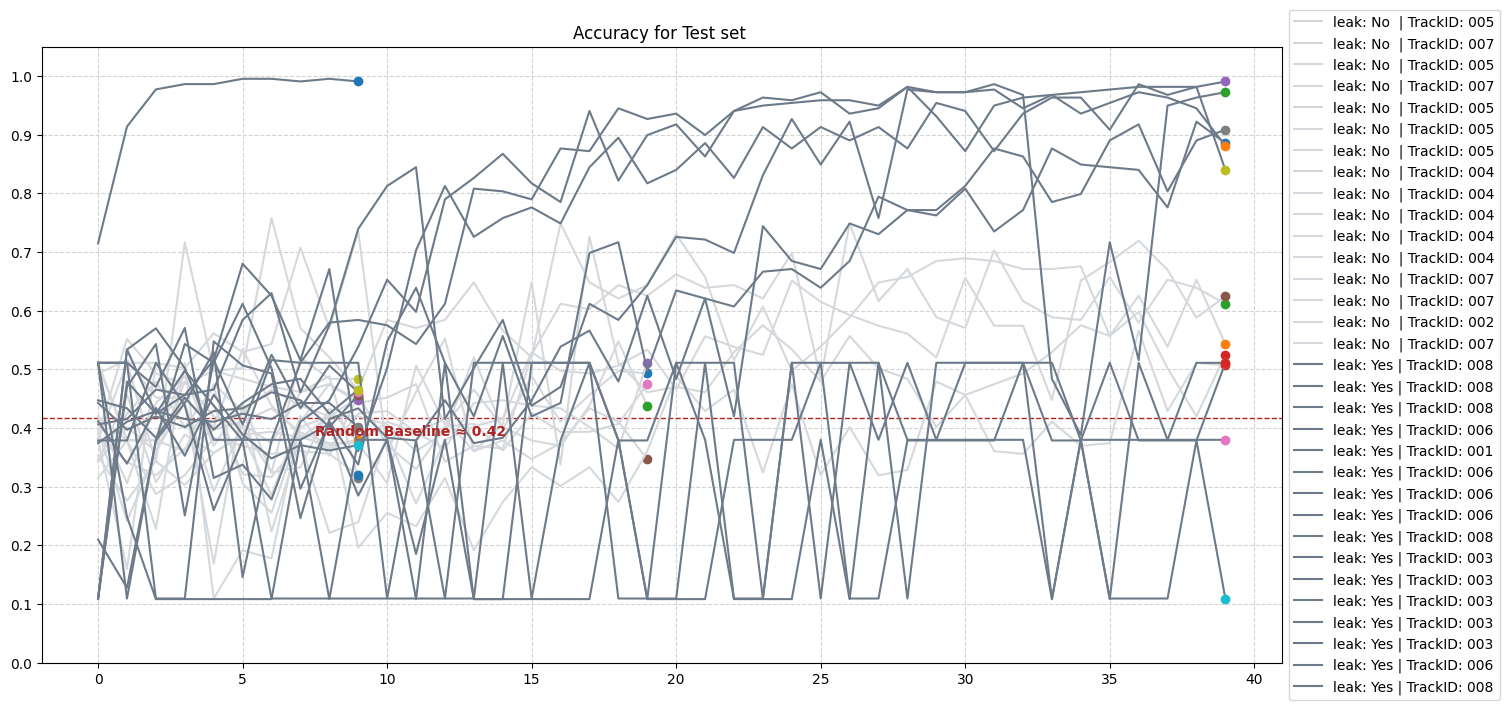

In [15]:
from matplotlib.lines import Line2D
custom_legend_handles1, custom_legend_handles2 = [], []
plt.figure(figsize=(16,8))
for r, data in d_metric_perf.sort_values(by=["leak"]).iterrows():

    #_______________________________________________________
    # Creating series label 
    leakage_exp = data["leak"]
    track = data["track_train_id"]
    
    leak = "Yes" if leakage_exp else "No "
    track = track.split("_")[1]
    serie_label_name = f"leak: {leak} | TrackID: {track}"

    #_______________________________________________________
    serie_values = data["metric_vals"]

    #_______________________________________________________
    color_line = "#6C7A89" if leakage_exp else "#D5D8DC"
    plt.plot(serie_values, label=serie_label_name, color=color_line, zorder=3)

    # last epoch performace
    sc = plt.scatter(len(serie_values) - 1, serie_values[-1], zorder=3)
    #----------------------------

    legend_label = (
        f'{serie_label_name}: '
        f'$\u2015$'  # Unicode for horizontal line
        f' (line)  '
        f'$\u25CF$'  # Unicode for filled circle with this color : sc.get_facecolor()[0]
        f' (marker)' 
    )
    custom_legend_handles1.append(Line2D(
        [0], [0],
        color=color_line,
        # marker='o',
        # markerfacecolor=sc.get_facecolor()[0],
        # label=f'{serie_label_name}: line + marker'
        label=legend_label,
    ))
    # custom_legend_handles2.append(Line2D(
    #     [0], [0],
    #     # color=color_line,
    #     marker='o',
    #     # markerfacecolor=sc.get_facecolor()[0],
    #     # label=f'{serie_label_name}: line + marker'
    #     label=legend_label,
    # ))




    #_______________________________________________________
    # break
#-----------------------------------------------------------
plt.axhline(expected_random_accuracy, color='firebrick', linestyle='--', linewidth=1, 
            # label='Random Baseline', 
           )
# Annotate the line
plt.text(
    x=7.5, 
    y=expected_random_accuracy - 0.03, 
    s=f'Random Baseline ≈ {expected_random_accuracy:.2f}',
    color='firebrick',
    fontsize=10,
    fontweight='bold'
)

plt.title("Accuracy for Test set ")
# plt.legend(handles=[(custom_legend_handles1, custom_legend_handles2)])
# plt.legend(handles=custom_legend_handles1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(color='lightgray', linestyle="--", zorder=0 )
plt.yticks(np.arange(0, 1.1, 0.1)) 
plt.ylim(0,1.05)
plt.show()

## Vanilla CNN

In [25]:
d_meta["architecture__arch_ID"].unique()

array(['vanilla2DCNN_v1', 'RESNET_v1', 'ALEXNET_v1', 'ALEXNET_v2'],
      dtype=object)

In [20]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="vanilla", 
                                        pipe_names=['pipe001'])
d_m

,track_train_id,pre_pipe_id,arch_name,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_002,pipe001,vanilla2DCNN_v1,False,10,acc_tst,1.0,0.447964,NaN,0.447964,0.447964,0.447964,0.447964,0.447964
1,TrainTrack_002,pipe001,vanilla2DCNN_v1,False,10,ba_tst,1.0,0.144174,NaN,0.144174,0.144174,0.144174,0.144174,0.144174
2,TrainTrack_002,pipe001,vanilla2DCNN_v1,False,10,f1score_tst,1.0,0.401953,NaN,0.401953,0.401953,0.401953,0.401953,0.401953
3,TrainTrack_002,pipe001,vanilla2DCNN_v1,False,10,prcsn_tst,1.0,0.452391,NaN,0.452391,0.452391,0.452391,0.452391,0.452391
4,TrainTrack_002,pipe001,vanilla2DCNN_v1,False,10,rec_tst,1.0,0.429449,NaN,0.429449,0.429449,0.429449,0.429449,0.429449
5,TrainTrack_001,pipe001,vanilla2DCNN_v1,True,10,acc_tst,1.0,0.990950,NaN,0.990950,0.990950,0.990950,0.990950,0.990950
6,TrainTrack_001,pipe001,vanilla2DCNN_v1,True,10,ba_tst,1.0,0.958333,NaN,0.958333,0.958333,0.958333,0.958333,0.958333
7,TrainTrack_001,pipe001,vanilla2DCNN_v1,True,10,f1score_tst,1.0,0.981586,NaN,0.981586,0.981586,0.981586,0.981586,0.981586
8,TrainTrack_001,pipe001,vanilla2DCNN_v1,True,10,prcsn_tst,1.0,0.992248,NaN,0.992248,0.992248,0.992248,0.992248,0.992248
9,TrainTrack_001,pipe001,vanilla2DCNN_v1,True,10,rec_tst,1.0,0.972222,NaN,0.972222,0.972222,0.972222,0.972222,0.972222


## RESNET | PIPE001

In [21]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="resnet", 
                                        pipe_names=['pipe001'])
d_m

,track_train_id,pre_pipe_id,arch_name,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_004,pipe001,RESNET_v1,False,10,acc_tst,5.0,0.390173,0.076411,0.315068,0.319635,0.380090,0.452055,0.484018
1,TrainTrack_004,pipe001,RESNET_v1,False,10,ba_tst,5.0,-0.037453,0.102910,-0.179486,-0.084588,-0.013801,-0.008122,0.098734
2,TrainTrack_004,pipe001,RESNET_v1,False,10,f1score_tst,5.0,0.308619,0.066307,0.216061,0.278157,0.325545,0.328671,0.394660
3,TrainTrack_004,pipe001,RESNET_v1,False,10,prcsn_tst,5.0,0.322586,0.069035,0.219157,0.304517,0.326860,0.357217,0.405180
4,TrainTrack_004,pipe001,RESNET_v1,False,10,rec_tst,5.0,0.308365,0.068607,0.213676,0.276941,0.324133,0.327919,0.399156
5,TrainTrack_005,pipe001,RESNET_v1,False,20,acc_tst,5.0,0.453013,0.065110,0.347032,0.438356,0.475113,0.493151,0.511416
6,TrainTrack_005,pipe001,RESNET_v1,False,20,ba_tst,5.0,0.050797,0.102994,-0.086650,0.007375,0.040824,0.105332,0.187106
7,TrainTrack_005,pipe001,RESNET_v1,False,20,f1score_tst,5.0,0.361070,0.063586,0.283421,0.328135,0.345455,0.403537,0.444803
8,TrainTrack_005,pipe001,RESNET_v1,False,20,prcsn_tst,5.0,0.369845,0.055634,0.316453,0.318051,0.365633,0.403982,0.445105
9,TrainTrack_005,pipe001,RESNET_v1,False,20,rec_tst,5.0,0.367198,0.068662,0.275567,0.338250,0.360549,0.403555,0.458070


## ALEXNET | PIPE001

In [22]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="alexnet", 
                                        pipe_names=['pipe001'])
d_m

,track_train_id,pre_pipe_id,arch_name,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_007,pipe001,ALEXNET_v1,False,40,acc_tst,5.0,0.562330,0.052758,0.506849,0.525114,0.543379,0.611872,0.624434
1,TrainTrack_007,pipe001,ALEXNET_v1,False,40,ba_tst,5.0,0.354226,0.178974,0.173318,0.204541,0.384466,0.388267,0.620536
2,TrainTrack_007,pipe001,ALEXNET_v1,False,40,f1score_tst,5.0,0.513167,0.070320,0.432474,0.468078,0.492253,0.582160,0.590870
3,TrainTrack_007,pipe001,ALEXNET_v1,False,40,prcsn_tst,5.0,0.599023,0.092001,0.484685,0.525867,0.612328,0.679622,0.692610
4,TrainTrack_007,pipe001,ALEXNET_v1,False,40,rec_tst,5.0,0.569484,0.119316,0.448879,0.469694,0.589644,0.592178,0.747024
5,TrainTrack_006,pipe001,ALEXNET_v1,True,40,acc_tst,5.0,0.598153,0.345231,0.109589,0.511312,0.511416,0.885845,0.972603
6,TrainTrack_006,pipe001,ALEXNET_v1,True,40,ba_tst,5.0,0.335216,0.464354,0.000000,0.000000,0.000000,0.738723,0.937357
7,TrainTrack_006,pipe001,ALEXNET_v1,True,40,f1score_tst,5.0,0.459009,0.400856,0.065844,0.225549,0.225579,0.820759,0.957314
8,TrainTrack_006,pipe001,ALEXNET_v1,True,40,prcsn_tst,5.0,0.430114,0.423156,0.036530,0.170437,0.170472,0.816596,0.956536
9,TrainTrack_006,pipe001,ALEXNET_v1,True,40,rec_tst,5.0,0.556811,0.309570,0.333333,0.333333,0.333333,0.825815,0.958238


**My Notes:**

Keep in mind that vanillaCNN reach high performance with leackage, which mean that lower performances in more complex architecture are more likely for need of better tunning in training parameters (lr, gradient clipping) or some type of normalization within the architecture since pipe001 create an img with raw pixel values (0-255)

- ALEXNET_v1 -> normal architecture
- ALEXNET_v2 -> adding layer of batch normalization

________
**Next Step:**
- ALEXNET_v2, leakage=False, epoch=40.
- Add to "training configuration" params, and ID related to training step parameters > to easy compare experiment with equal training configuration. 